In [3]:
# 라이브러리
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,}'.format

# 한글 맥OS 기준
plt.rc('font', family='AppleGothic')
%config InlineBackend.figure_format = 'retina'
# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# 모델링
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from scipy.optimize import minimize

In [17]:
# 추천시스템 모델링
import surprise
from surprise import Dataset
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy

# EDA

In [ ]:
pdde = pd.read_csv('./LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv')
pd_clac = pd.read_csv('./LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv')
demo = pd.read_csv('./LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv')
pdde.de_dt = pd.to_datetime(pdde.de_dt, format='%Y%m%d')
pdde = pd.merge(pdde, pd_clac, how='left', on='pd_c')

# 코로나 데이터
covid = pd.read_csv('/Users/jinc/Desktop/공모전/LPOINT_BIG_COMP/코로나바이러스감염증-19(COVID-19) 현황 누적 데이터/Covid19InfState_20220717.csv')
covid = covid[['stateDt','decideCnt']]
covid.columns = ['de_dt','decideCnt']
covid.de_dt = pd.to_datetime(covid.de_dt, format='%Y%m%d')
covid = covid.sort_values(by='de_dt')
covid.decideCnt = covid.decideCnt.diff()
# 2021년도 확진자 수 데이터만 추출
covid = covid[covid.de_dt.between(dt.datetime(2021,1,1), dt.datetime(2021,12,31))]

# 날짜 데이터에서 월 추출
pdde['month'] = pdde.de_dt.dt.month
covid['month'] = covid.de_dt.dt.month

In [ ]:
pdde.describe()

,chnl_dv,de_hr,buy_am,buy_ct,month
count,"4,381,743.0","4,381,743.0","4,381,743.0","4,381,743.0","4,381,743.0"
mean,1.0977923625370087,15.711085063637917,"23,212.53765841584",1.310360283567521,6.1857571290694136
std,0.29703372956962637,3.721817226781734,"229,809.6939251331",1.5961381858764139,3.4085769334510236
min,1.0,0.0,1.0,1.0,1.0
25%,1.0,13.0,"2,000.0",1.0,3.0
50%,1.0,16.0,"4,000.0",1.0,6.0
75%,1.0,18.0,"9,280.0",1.0,9.0
max,2.0,23.0,"64,000,000.0",100.0,12.0


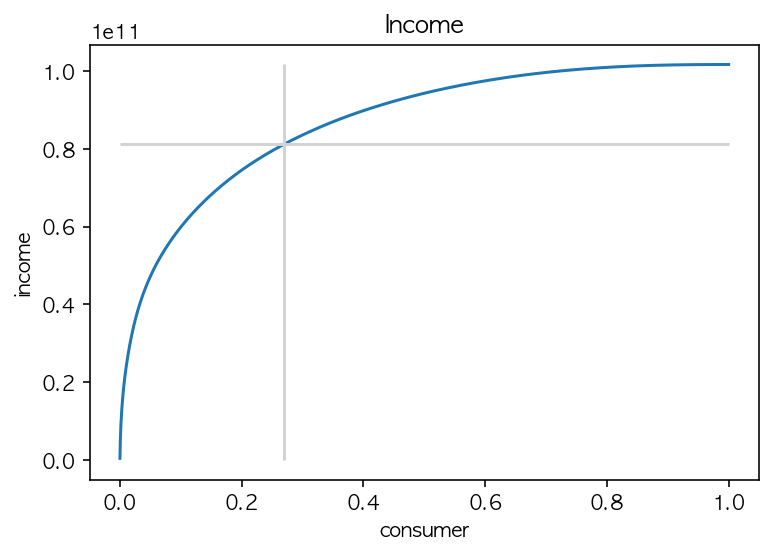

In [ ]:
# 누적 거래 금액 보기
cdm = pdde.groupby('cust').sum().buy_am.sort_values(ascending=False).expanding().sum()
eighty = pdde.buy_am.sum() * 0.80

x = [i for i in np.arange(0,1, 1/cdm.count())]
plt.plot(x,cdm.values)
plt.title('Income')
plt.xlabel('consumer')
plt.ylabel('income')
plt.hlines(eighty,0,1, colors='lightgrey')
plt.vlines(0.27,0,cdm.max(), colors='lightgrey')
plt.show()

- 기업 매출에 영향을 주는 고객들의 비율이 적음

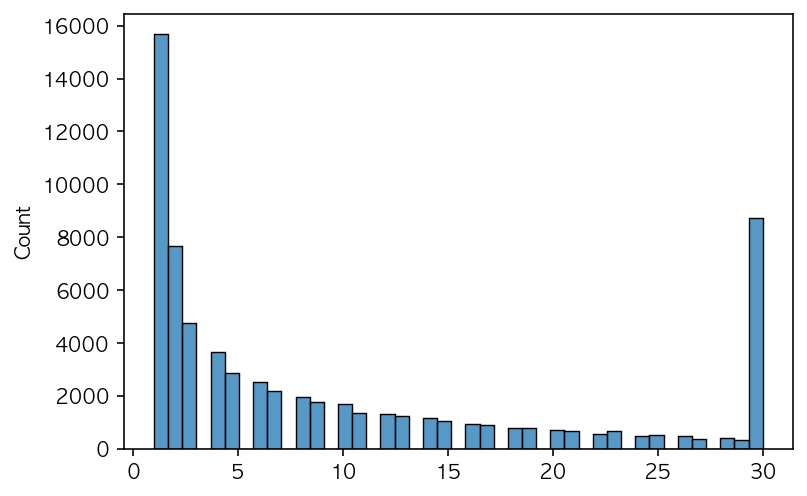

10days,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,29.0,30.0
visit,0.63,0.16,0.08,0.04,0.03,0.02,0.01,0.01,0.01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 거래 빈도
visit_count = pdde.groupby(['cust','cop_c']).agg(
                visit = ('de_dt', lambda x: x.drop_duplicates().count())
            )
visit_hist = np.where(visit_count.visit > 30, 30, visit_count.visit)
sns.histplot(visit_hist)
plt.show()    
# 10일 간격으로 그룹하여 빈도 수 체크
visit_count['10days'] = np.floor(visit_count.visit / 10)
(visit_count.groupby('10days').visit.count().to_frame().T / visit_count.shape[0]).round(2)

- 방문횟수가 10회 미만인 고객의 비율이 63%

In [ ]:
def visit_plot(data):
    visit_count = data.groupby('cust').agg(
                    visit = ('de_dt', lambda x: x.drop_duplicates().count())
                )
    sns.histplot(visit_count)

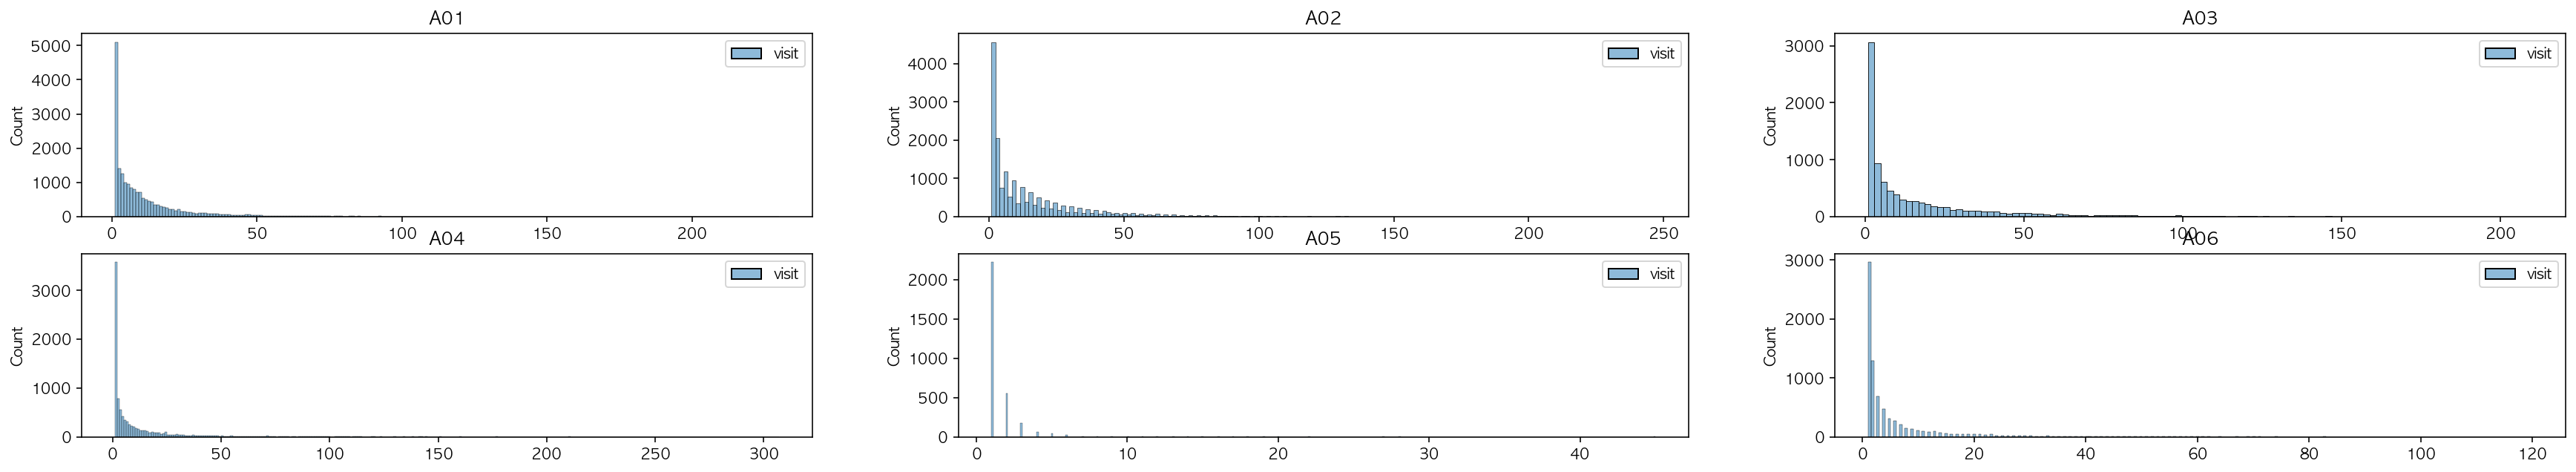

In [ ]:
a01 = pdde[pdde.cop_c=='A01']
a02 = pdde[pdde.cop_c=='A02']
a03 = pdde[pdde.cop_c=='A03']
a04 = pdde[pdde.cop_c=='A04']
a05 = pdde[pdde.cop_c=='A05']
a06 = pdde[pdde.cop_c=='A06']

plt.figure(figsize=(30,5))
for n, i in enumerate([a01,a02,a03,a04,a05,a06]):
    plt.subplot(2,3,n+1)
    plt.title(f'A0{n+1}')
    visit_plot(i)

In [ ]:
def unbound_retention(df):

    start_month = df.groupby('cust').agg(
        start_month = ('de_dt', lambda x: x.min().month)
    ).reset_index()

    last_month = df.groupby('cust').agg(
        last_month = ('de_dt', lambda x: x.max().month)
    ).reset_index()

    # 코호트 인덱스 각 구매 월 - 최초 구매 월
    cohort = df[['cust','de_dt']]
    cohort = cohort.merge(start_month, how='left', on='cust')
    cohort = cohort.merge(last_month, how='left', on='cust')
    cohort.last_month = (cohort.last_month - cohort.start_month) + 1

    cohort = cohort.groupby(['start_month','last_month']).cust.apply(pd.Series.nunique)
    cohort = cohort.reset_index()
    cohort = cohort.pivot_table(
        index='start_month',
        columns='last_month',
        values='cust'
    )

    total_cust = cohort.sum(axis=1)
    for i in list(reversed(range(12))):
        cohort.iloc[:,i] = total_cust - cohort.iloc[:,:i].sum(axis=1)

    cohort_size = cohort.iloc[:,0]
    retention = cohort.divide(cohort_size, axis=0)

    plt.figure(figsize=(10,8))
    plt.title('Retention rates')
    sns.heatmap(data=retention,
                annot = True,
                fmt= '.0%',
                vmin = 0.0,
                vmax = 0.5,
                cmap = 'Blues')
    plt.show()

    return retention.replace(0, np.nan).mean()


***************************유통사 통합***************************


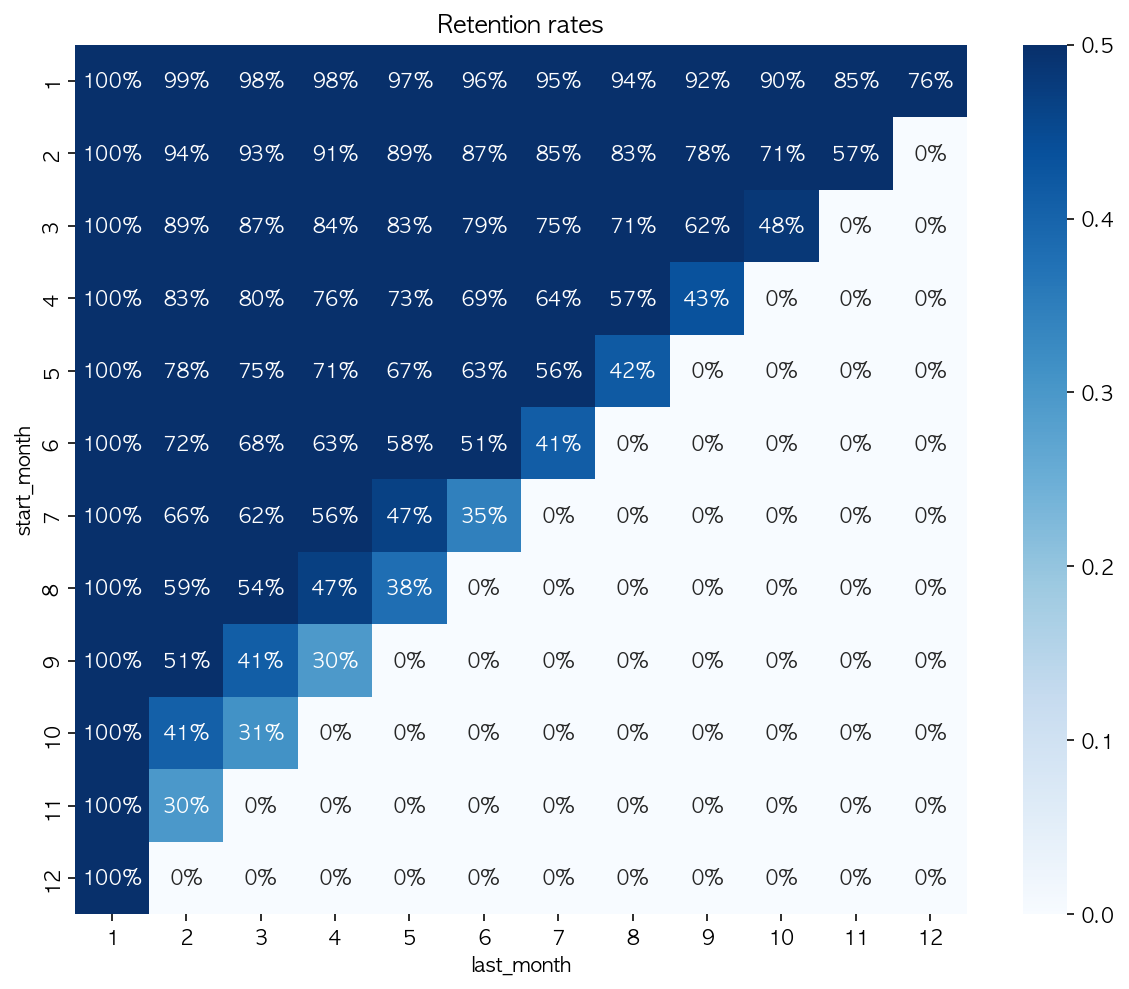


****************************A01*****************************


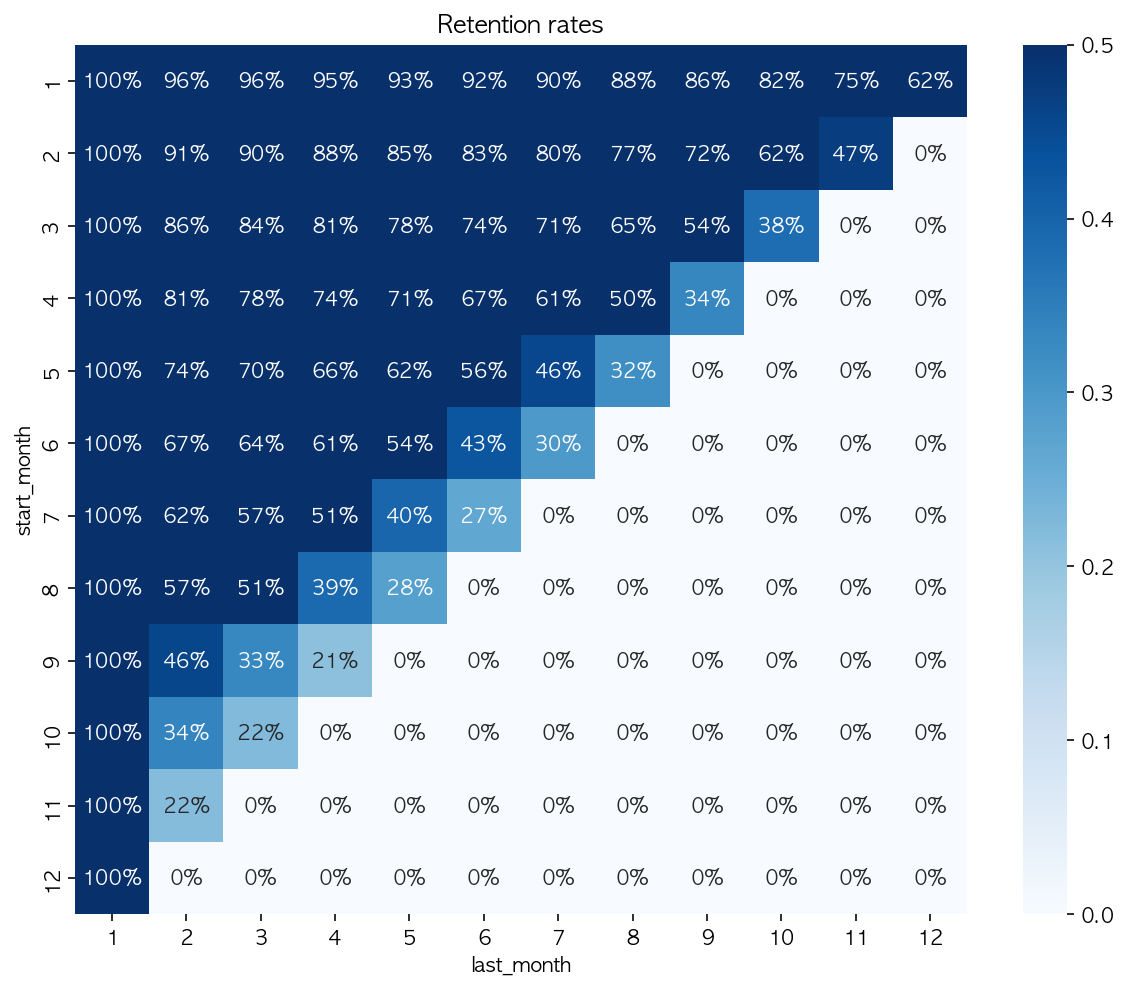


****************************A02*****************************


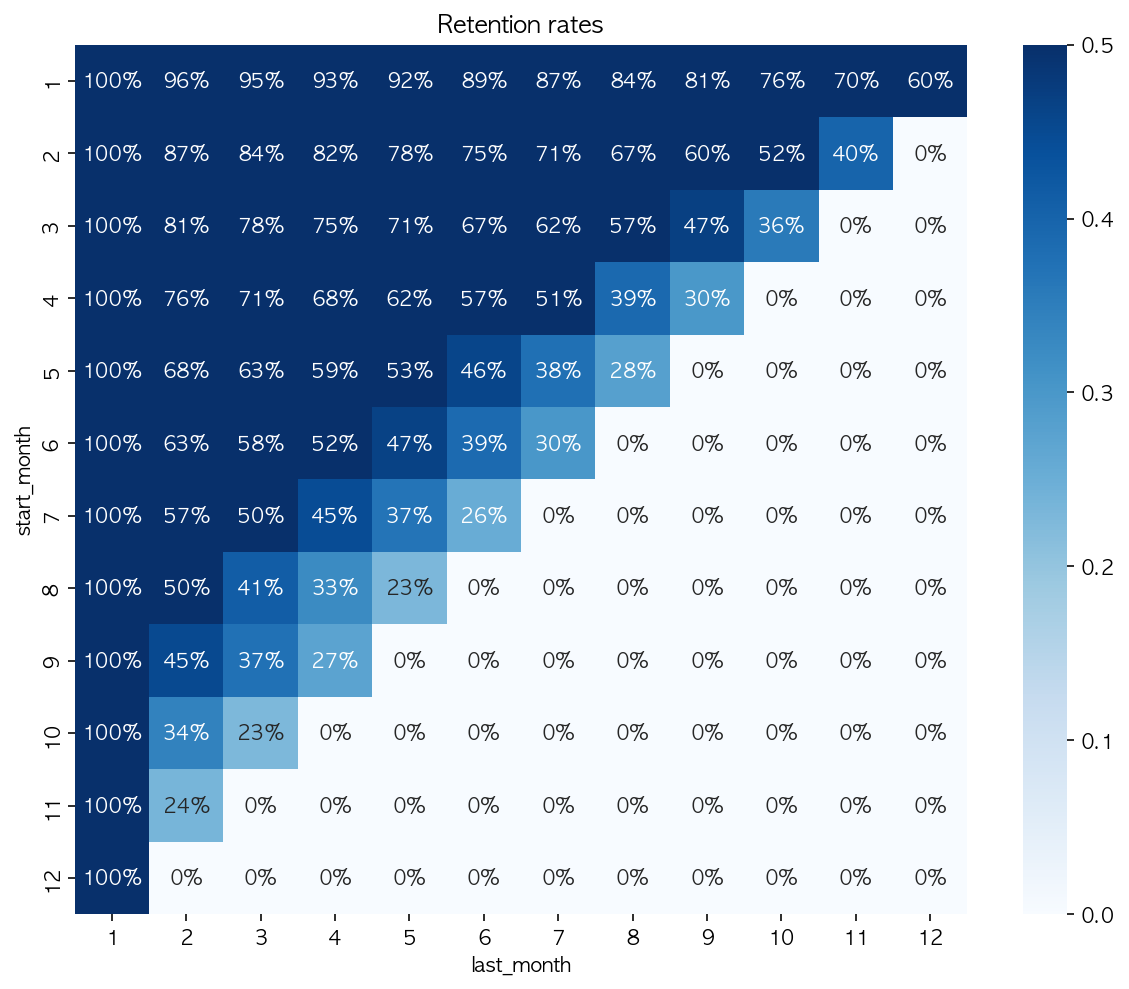


****************************A03*****************************


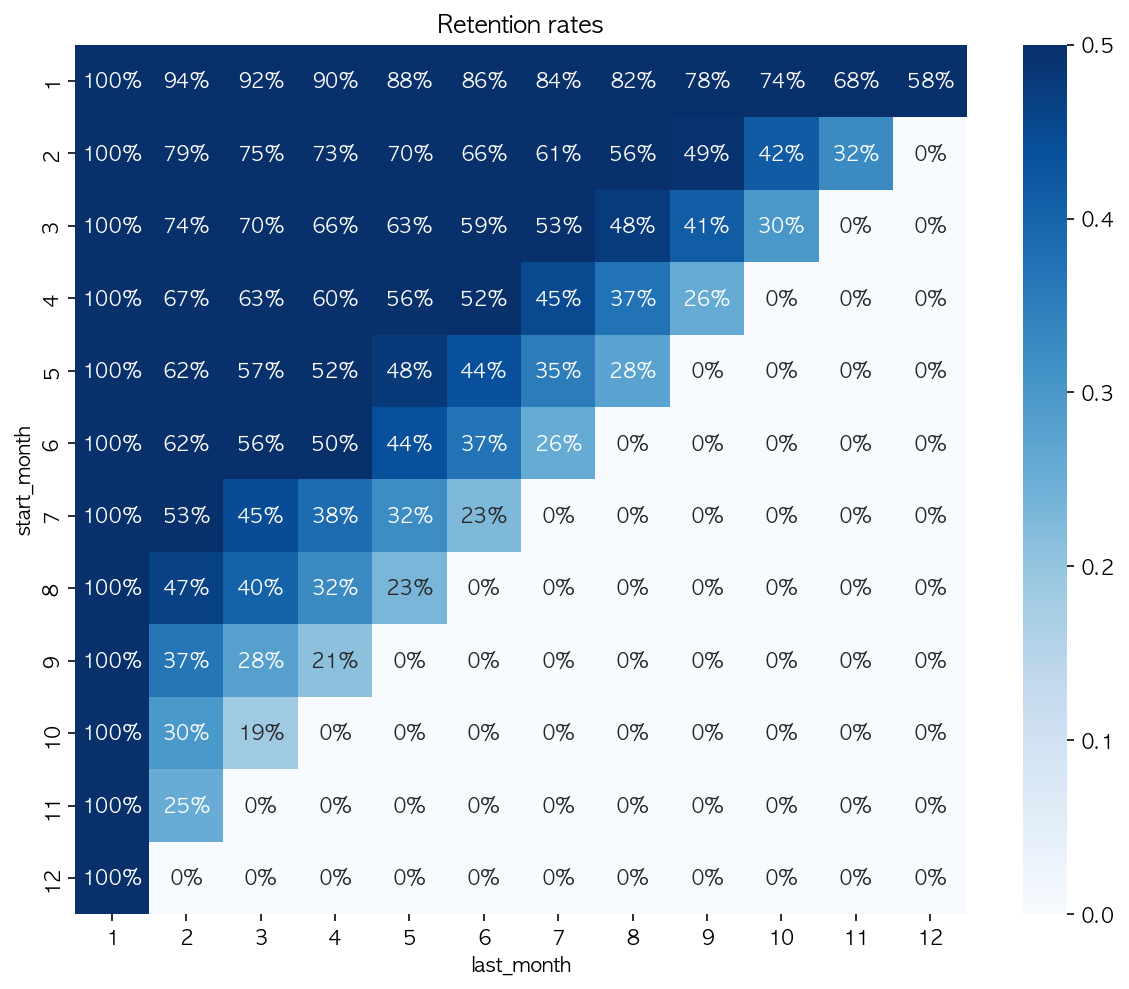


****************************A04*****************************


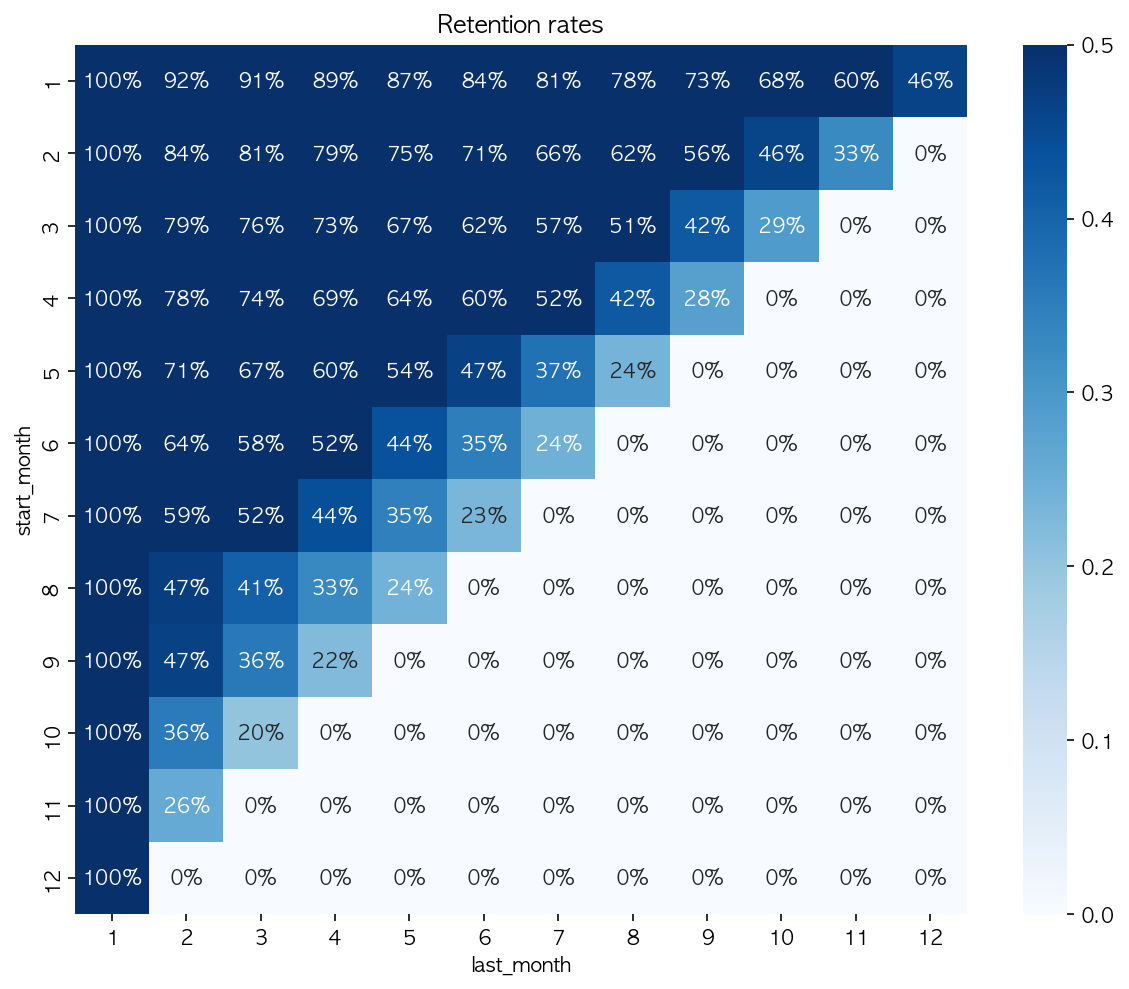


****************************A05*****************************


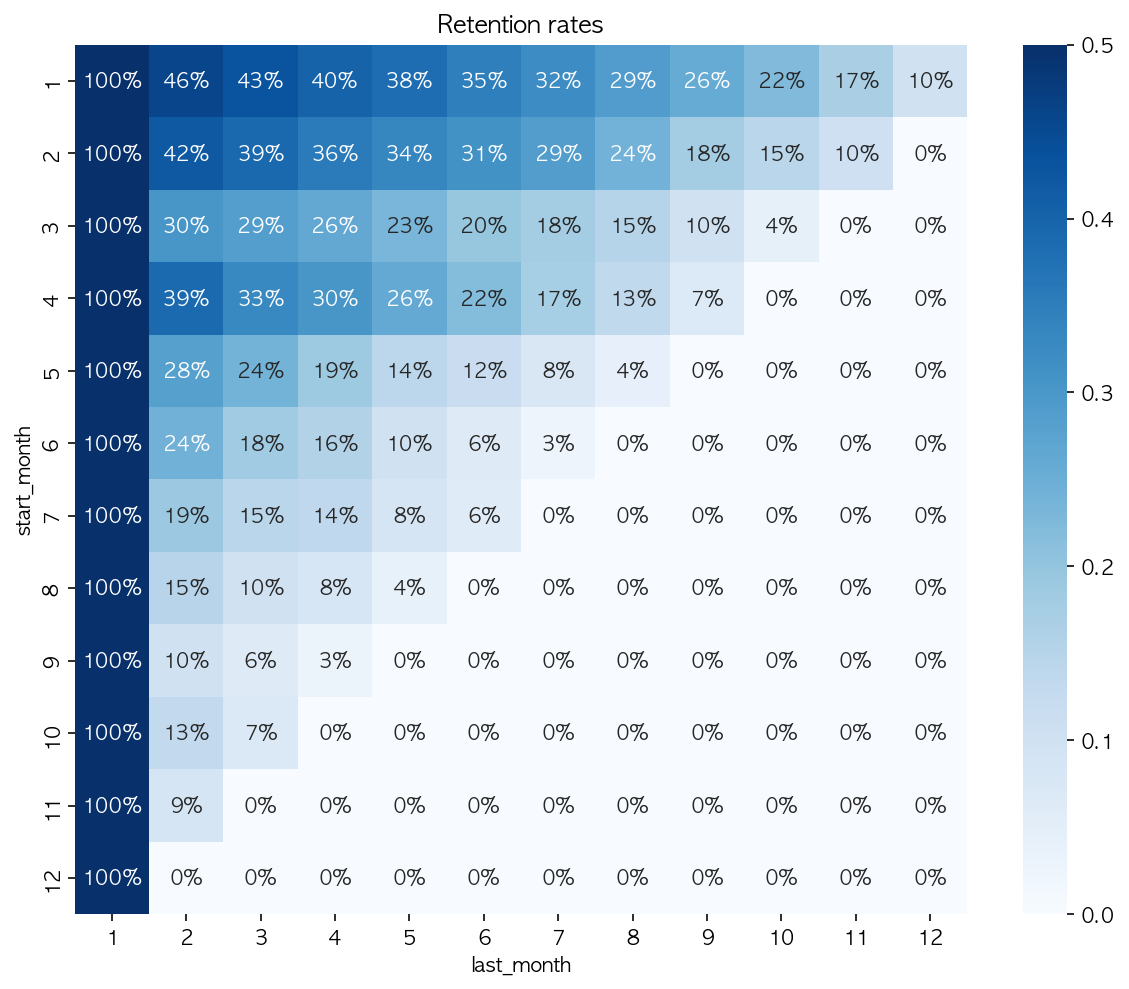


****************************A06*****************************


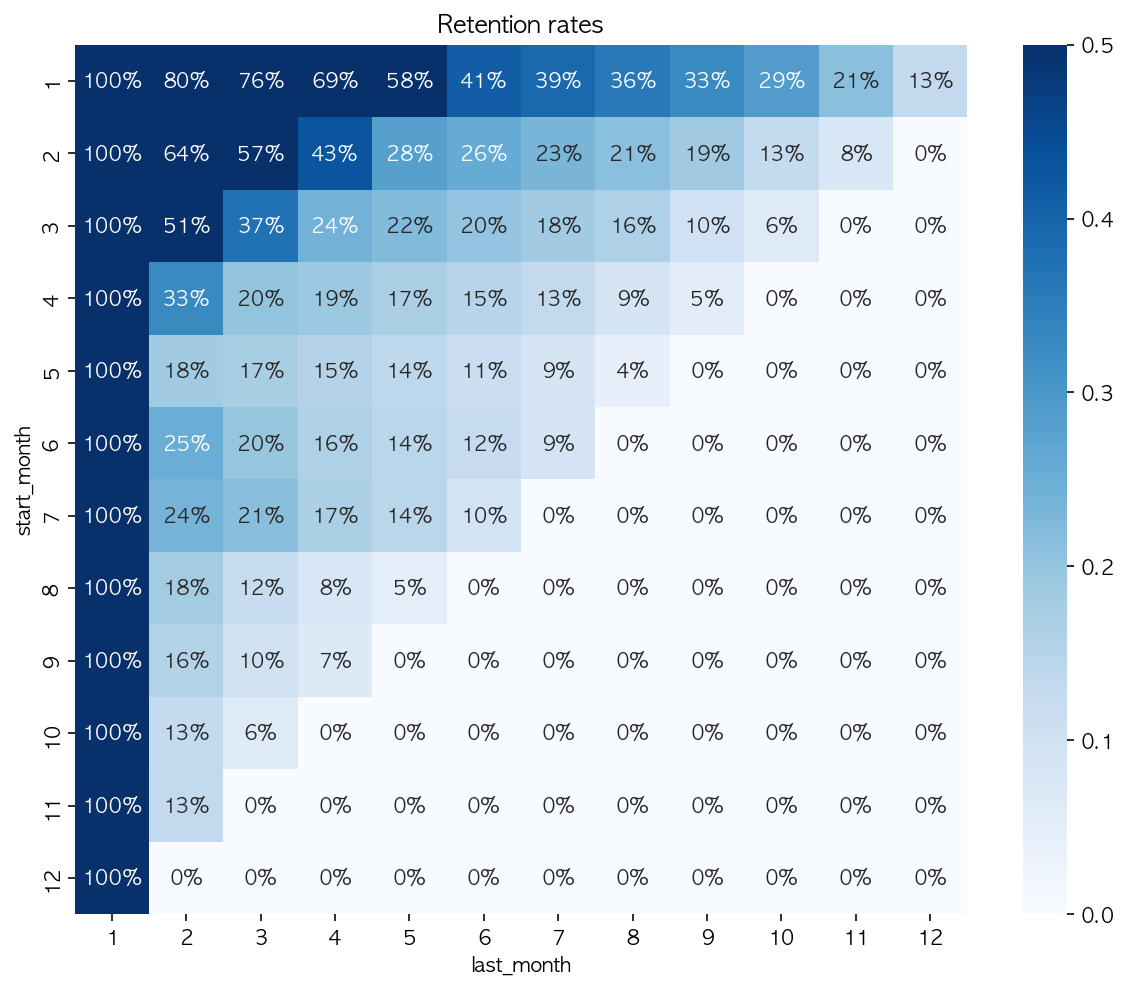

In [ ]:
# 유지율 코호트 분석
print('\n{:*^60}'.format("유통사 통합"))
unbound_retention(pdde)
print('\n{:*^60}'.format("A01"))
a01_retention = unbound_retention(a01)
print('\n{:*^60}'.format("A02"))
a02_retention = unbound_retention(a02)
print('\n{:*^60}'.format("A03"))
a03_retention = unbound_retention(a03)
print('\n{:*^60}'.format("A04"))
a04_retention = unbound_retention(a04)
print('\n{:*^60}'.format("A05"))
a05_retention = unbound_retention(a05)
print('\n{:*^60}'.format("A06"))
a06_retention = unbound_retention(a06)

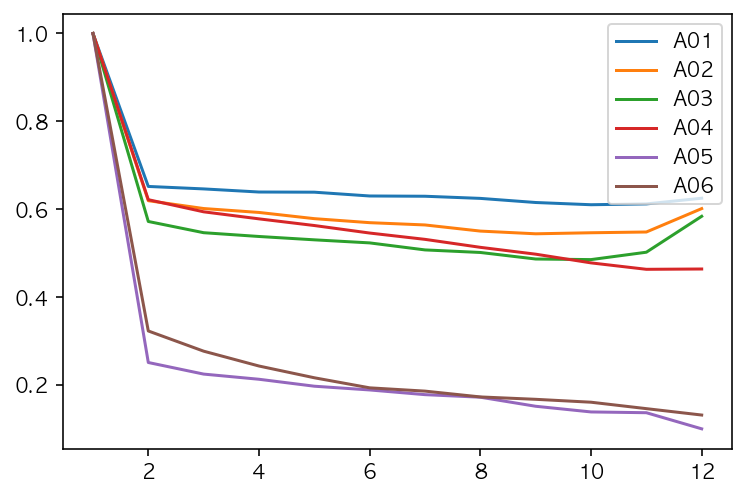

In [ ]:
cop_retention = [a01_retention, a02_retention, a03_retention, a04_retention, a05_retention, a06_retention]
# plt.figure(figsize=(15,5))
for n, i in enumerate(cop_retention):
    plt.plot(i, label=f'A0{n+1}')
    plt.legend()

- A05와 A06만이 좋은 유지율을 보여주지 못하고 있음

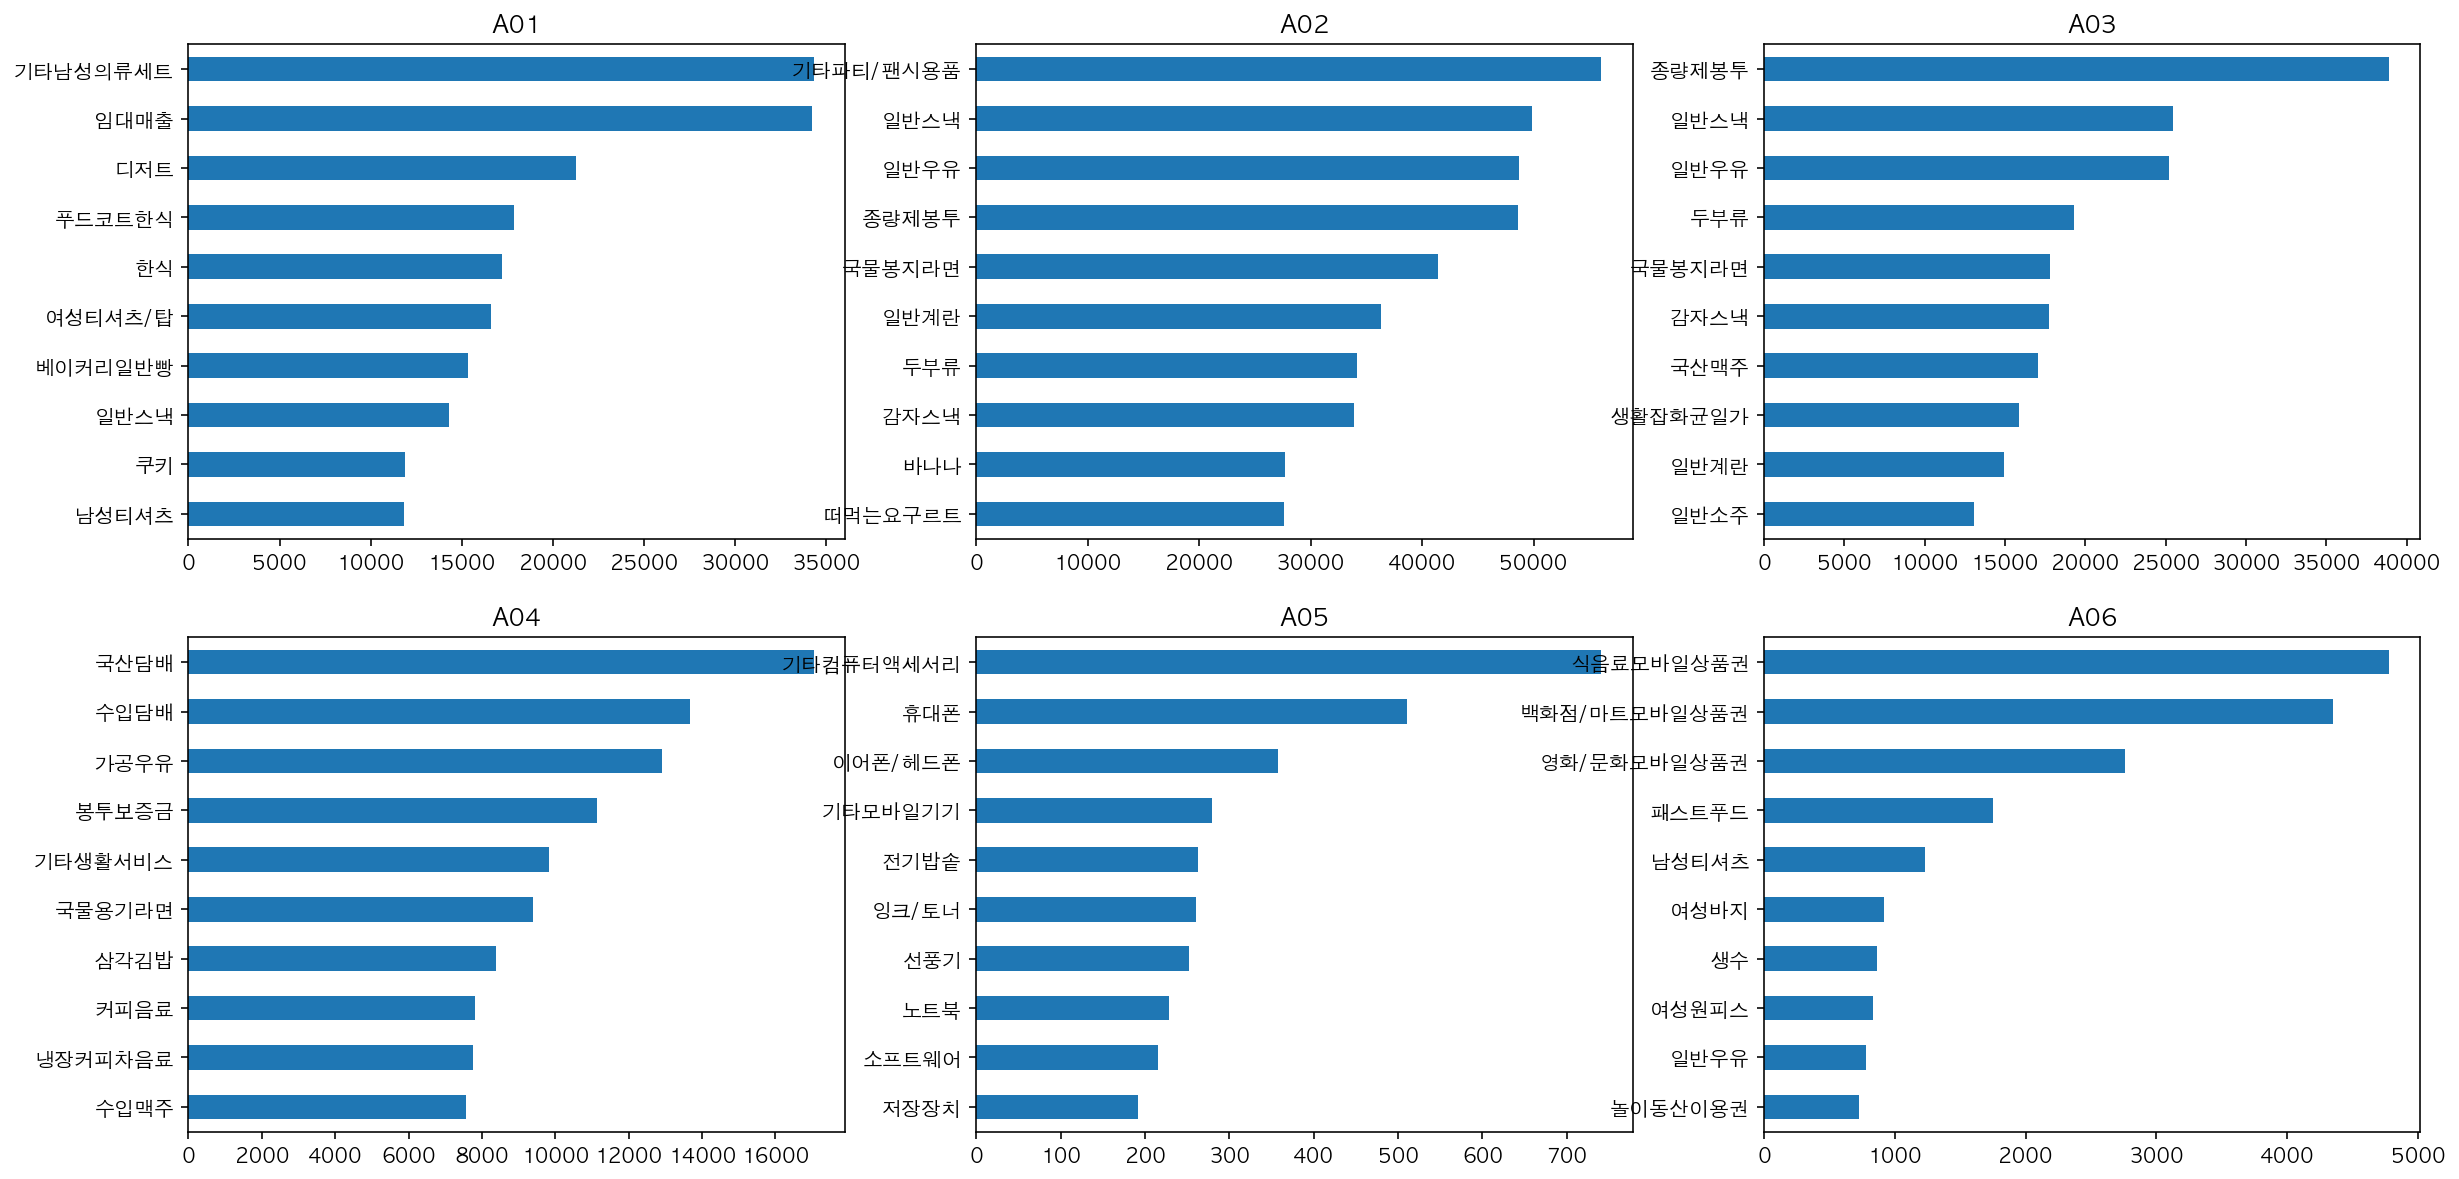

In [ ]:
# 유통사 종류 알아보기
plt.figure(figsize=(20,10))
for n, i in enumerate([a01,a02,a03,a04,a05,a06]):
    plt.subplot(2,3,n+1)
    plt.title(f'A0{n+1}')
    i.pd_nm.value_counts().head(10).sort_values(ascending=True).plot.barh()

- 주요 판매 상품을 보고 추정되는 유통사:
    - A01: 백화점
    - A02: 대형마트 / 백화점
    - A03: 중형마트
    - A04: 편의점 / 동네마트
    - A05: 전자제품 스토어

온라인 비율: 0.09779236253700874


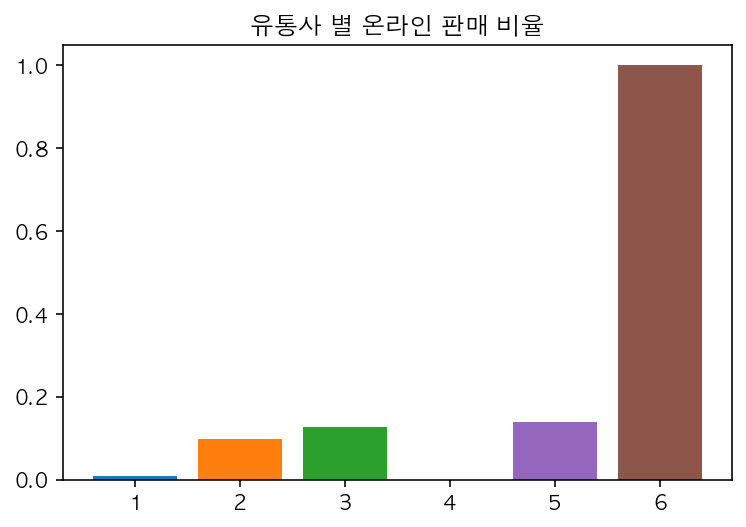

In [ ]:
# 온/오프라인 비율
print('온라인 비율:',pdde.chnl_dv.mean() - 1)
plt.title('유통사 별 온라인 판매 비율')
for n, i in enumerate([a01, a02, a03, a04, a05, a06]):
    plt.bar(n+1, i.chnl_dv.mean()-1)


- A06을 제외하면 대부분의 거래가 오프라인으로 이루어짐

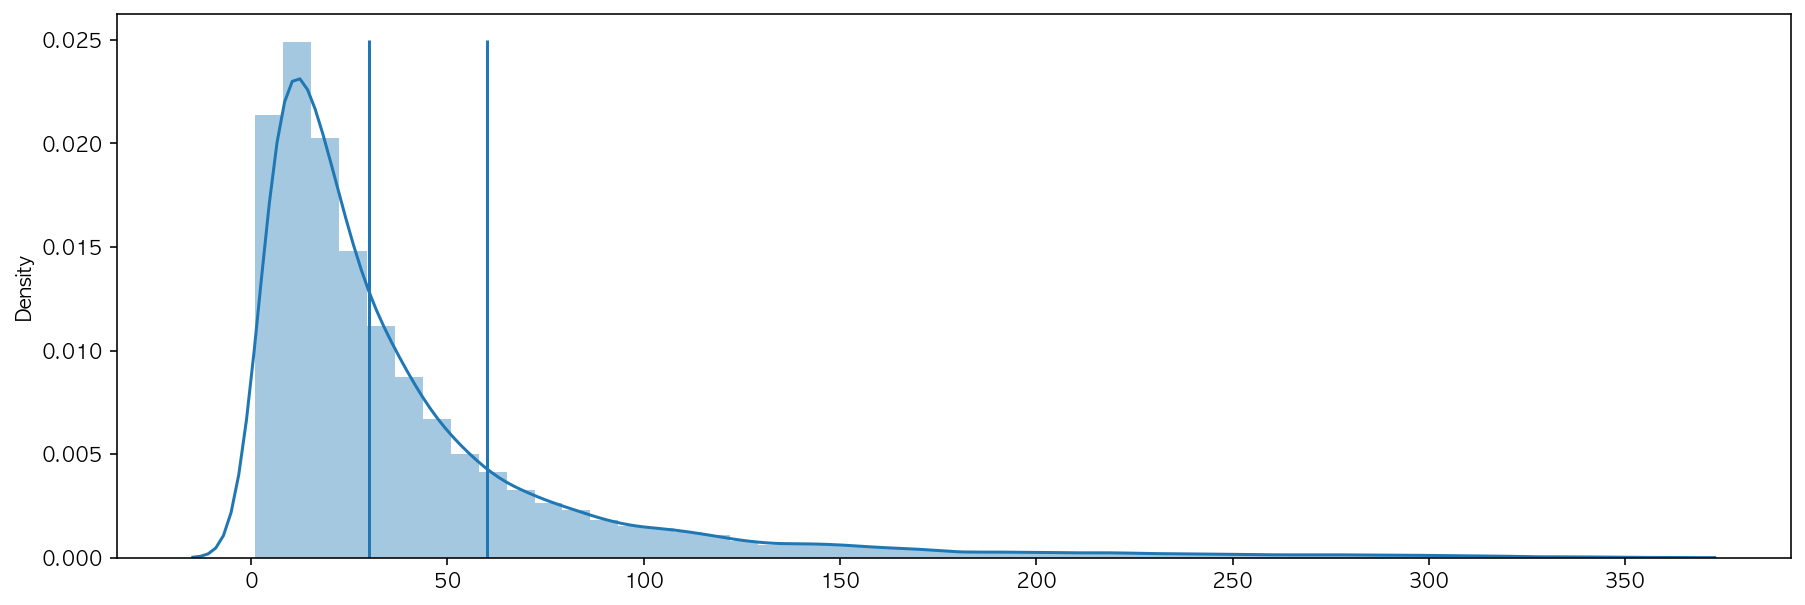

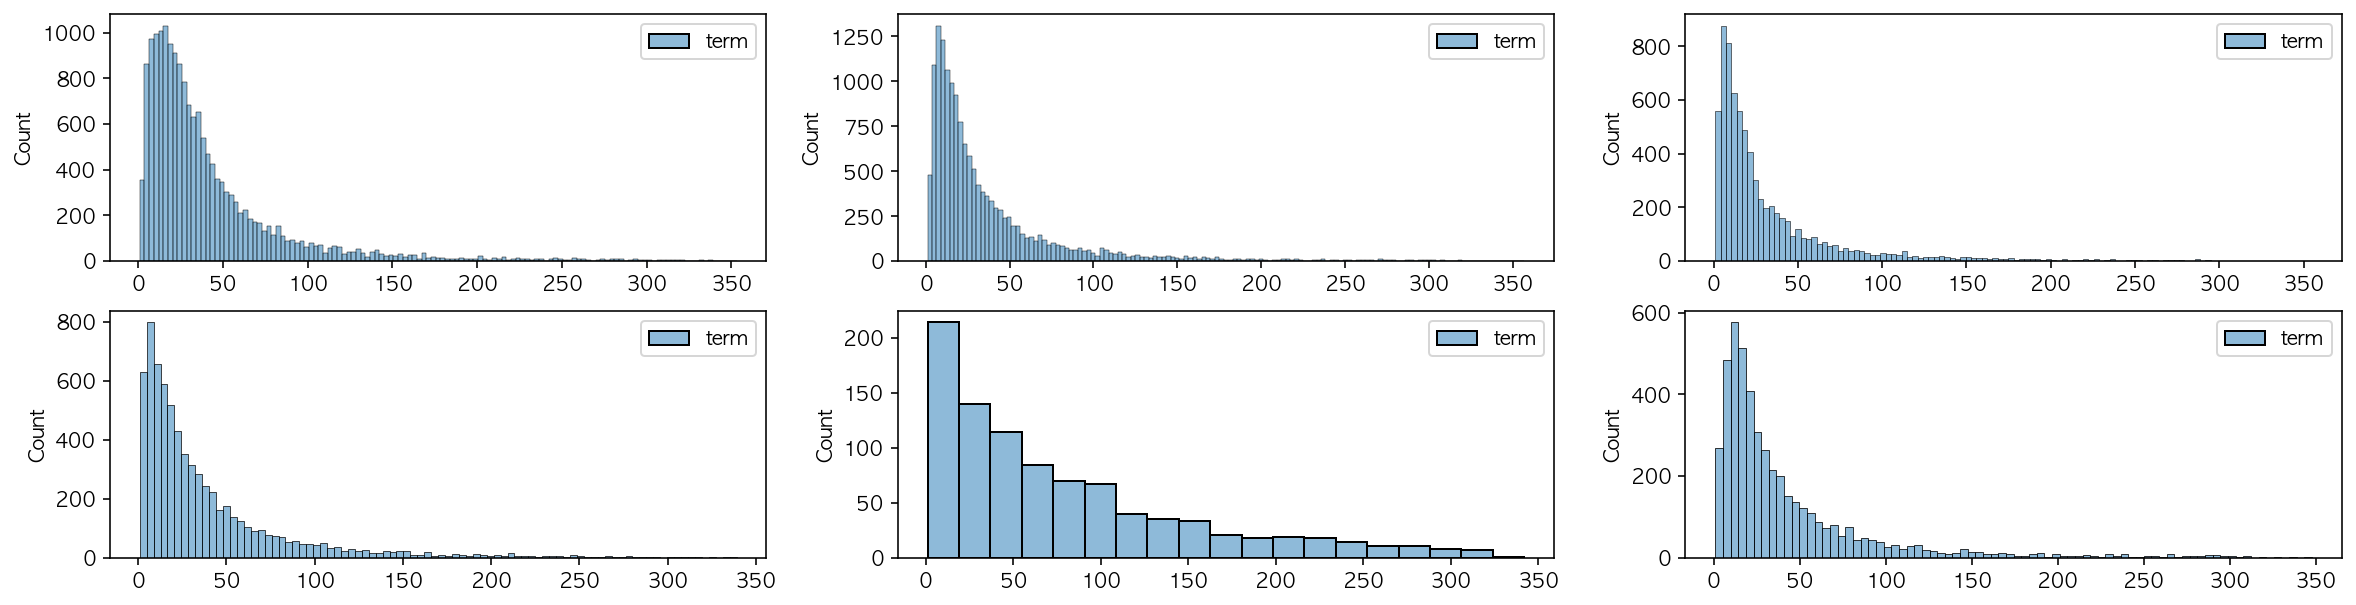

In [ ]:
# 방문 텀 알아보기
term = pdde.groupby(['cust','cop_c']).agg(
                term = ('de_dt', lambda x: x.sort_values().drop_duplicates().diff().dt.days.mean())
            )
# 한 번만 방문한 고객 제거
term = term.dropna()
# term.term = np.where(term.term > 90, 90, term.term)
plt.figure(figsize=(15,5))
sns.distplot(term)
plt.vlines(30, 0, 0.025)
plt.vlines(60, 0, 0.025)

plt.figure(figsize=(20,5))
for n, i in enumerate([a01, a02, a03, a04, a05, a06]):
    plt.subplot(2,3,n+1)
    term = i.groupby('cust').agg(
                term = ('de_dt', lambda x: x.sort_values().drop_duplicates().diff().dt.days.mean())
            )
    # 한 번만 방문한 고객 제거
    term = term.dropna()
    sns.histplot(term)

In [ ]:
def visit_term(data):
    term = data.groupby(['cust','cop_c']).agg(
                    term = ('de_dt', lambda x: x.sort_values().drop_duplicates().diff().dt.days.mean())
                )
    print('1개월 이상:', round((term[term.term >= 30].shape[0] / term.shape[0])*100, 2))
    print('2개월 이상:', round((term[term.term >= 60].shape[0] / term.shape[0])*100, 2))

In [ ]:
# 한번 이상 방문 고객 중 방문 평균 텀이 2개월 이상인 비율
print('고객 평균 방문 텀')
visit_term(pdde)

고객 평균 방문 텀
1개월 이상: 31.98
2개월 이상: 14.33


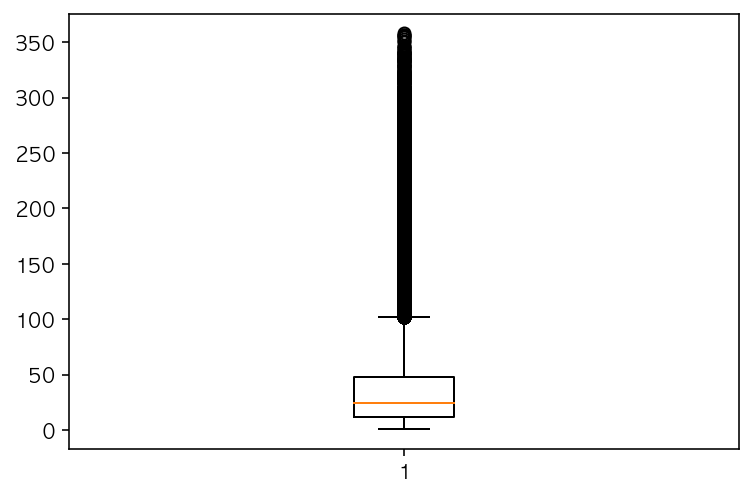

In [ ]:
# 방문 평균 텀 boxplot
term = pdde[(pdde.cop_c!='A05') & (pdde.cop_c!='A06') & (pdde.pd_c!='PD0288')].groupby(['cust','cop_c']).agg(
                            term = ('de_dt', lambda x: x.sort_values().drop_duplicates().diff().dt.days.mean())
)
term = term.dropna()
plt.boxplot(term)
plt.show()

In [ ]:
# 코로나와 방문자 수  
visit_by_date = pdde[['cust','de_dt','month']].drop_duplicates()
visit_by_date = visit_by_date.groupby('de_dt').agg(
                visit = ('cust','count'),
                month = ('month','first')
            ).reset_index()

by_date = pd.merge(visit_by_date, covid, how='left', on='de_dt')

# 월 방문자 수와 확진자 수 추출
# 방문자 수 
visit_by_month = visit_by_date.groupby('month').agg(
                visit = ('visit','sum')
            ).reset_index()

# 코로나 확진자 수 
covid_by_month = covid.groupby('month').agg(
    decide = ('decideCnt','sum')
).reset_index()

by_month = pd.merge(visit_by_month, covid_by_month, how='left', on='month')

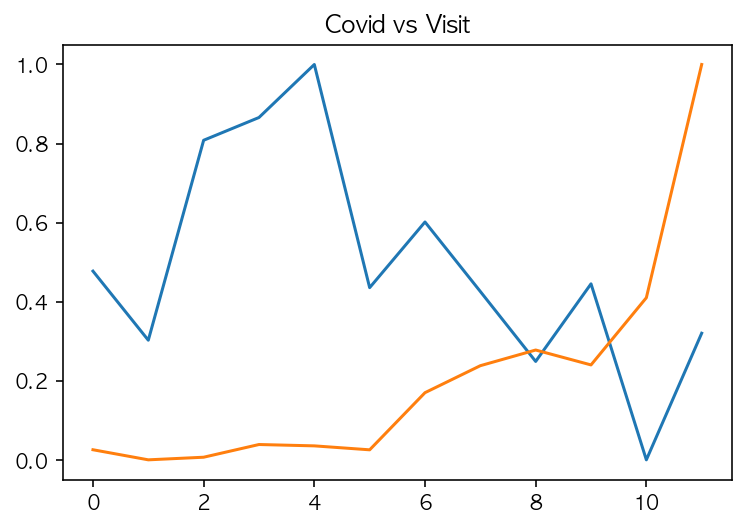

In [ ]:
# 직접적으로 비교하기 위해 표준화
sc = MinMaxScaler()
by_month[['sc_visit','sc_decide']] = sc.fit_transform(by_month[['visit','decide']])
# 시각화하여 비교
plt.title('Covid vs Visit')
plt.plot(by_month.sc_visit)
plt.plot(by_month.sc_decide)
plt.show()

In [ ]:
smf.ols(formula='visit ~ decideCnt', data=by_date).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  visit   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     17.38
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           3.88e-05
Time:                        21:05:58   Log-Likelihood:                -2532.8
No. Observations:                 346   AIC:                             5070.
Df Residuals:                     344   BIC:                             5077.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2428.7232     25.230     96.263      0.000    2379.098    2478.348
decideCnt     -0.0399      0.010     -4.169      0.000      -0.059      -0.021
==============================================================================
Omnibus:                       39.736   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.720
Skew:                          -0.635   Prob(JB):                     8.06e-18
Kurtosis:                       4.962   Cond. No.                     3.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 확진자 수와 방문자 수는 음의 상관관계를 가지고 있음

# 모델링

### 데이터 전처리

In [22]:
# 데이터 불러오기
pdde = pd.read_csv('/content/drive/MyDrive/L.Pay_Competition/LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv')
# PD0288 -> 임대매출 거래 제거
pdde = pdde[pdde.pd_c!='PD0288']
pdde = pdde.drop(columns=['rct_no','br_c','pd_c'])
# A05와 A06 유통사 데이터 제거
pdde = pdde[(pdde.cop_c!='A05') & (pdde.cop_c!='A06')]
# datetime 타입으로 변환
pdde.de_dt = pd.to_datetime(pdde.de_dt, format='%Y%m%d')
pdde['week'] = pdde.de_dt.dt.weekofyear
pdde['week'] = np.where(pdde.week==53, 0, pdde.week)
# cust를 유통사별로 고유 id 생성
pdde['id'] = pdde.groupby(['cust','cop_c']).ngroup()
# id별 첫 구매일 구하기
start_date = pdde.groupby('id').agg(
            first = ('de_dt', lambda x: x.min())
        ).reset_index()
pdde = pd.merge(pdde, start_date, how='left', on='id')

In [23]:
# 주차별 감염재생산지수 변수 추가
Rt = pd.read_csv('/content/drive/MyDrive/L.Pay_Competition/LPOINT_BIG_COMP/2021_주차별 감염재상산지수.csv')
Rt['week'] = [i for i in range(52)]
pdde = pd.merge(pdde, Rt[['week','Rt']], how='left', on='week')

In [24]:
# train val test split
# Observation period 2개월 단위로 나누기
def split_data(point):
    set = pdde[pdde.de_dt.dt.month.between(point-2, point-1)]
    # Observation point (기준점)
    obs_point = dt.datetime(2021, point, 1)
    # y 생성
    # sliding window 기준점 ~ 7일
    sliding_window = pdde[pdde.de_dt.between(obs_point, obs_point+dt.timedelta(6))]
    predict_window = pdde[pdde.de_dt.between(obs_point+dt.timedelta(7), obs_point+dt.timedelta(37))]
    sliding_window = sliding_window.groupby('id').agg(
                        sliding_date = ('de_dt','max')
            ).reset_index()
    predict_window = predict_window.groupby('id').agg(
                predict_date = ('de_dt','min')
            ).reset_index()
    # sliding window에서의 거래일과 prediction window에서의 거래일 간의 차가 30 이상이면 y=1
    window = pd.merge(sliding_window, predict_window, how='outer', on='id')
    window['sliding_date'] = window.sliding_date.fillna(obs_point - dt.timedelta(1))
    window['range'] = (window.predict_date - window.sliding_date).dt.days
    window['range'] = window.range.fillna(99)
    window['y'] = np.where(window.range > 30, 1, 0)

    target = window[window.y==0].id.unique()
    set['y'] = set.id.isin(target)==False
    set['y'] = set.y.astype('int')
    return set

In [25]:
# Observation point(기준점)을 3, 5, 7, 9, 11 각 월의 1일로 설정
train1 = split_data(3)
train2 = split_data(5)
val1 = split_data(7)
val2 = split_data(9)
test = split_data(11)

### 변수 생성

In [26]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

def feature_engi(data):
    # 사용할 변수들 aggregate 
    month = data.de_dt.max().month + 1
    data_agg = data.groupby('id').agg(
            first = ('first', lambda x: (dt.datetime(2021,month,1) - x.max()).days),
            recency = ('de_dt', lambda x: (dt.datetime(2021,month,1) - x.max()).days),
            frequency = ('de_dt', lambda x: x.drop_duplicates().count()),
            monetary = ('buy_am','sum'),
            time = ('de_hr','mean'),
            chnl = ('chnl_dv','mean'),
            Rt = ('Rt','mean'),
            y = ('y','first')
        ).reset_index().round(4)
    
    # 유통사 더미 변수 생성
    data_cop = data[['id','cop_c','buy_ct']]
    data_cop = data_cop.groupby(['id','cop_c']).buy_ct.sum().unstack().reset_index().fillna(0).set_index('id')
    data_cop = data_cop.applymap(encode_units)
    data_cop = data_cop.reset_index()

    # 데이터 합치기 
    data_final = pd.merge(data_cop, data_agg, how='left', on='id')

    return data_final


In [27]:
train1_engi = feature_engi(train1)
train2_engi = feature_engi(train2)
train2_engi.id += 100000
train_engi = pd.concat([train1_engi, train2_engi])

val1_engi = feature_engi(val1)
val2_engi = feature_engi(val2)
val1_engi.id += 200000
val2_engi.id += 300000
val_engi = pd.concat([val1_engi, val2_engi])

test_engi = feature_engi(test)

### 고객 세분화

In [28]:
def good_cust(train, test):
  # RFM 변수를 사용하여 클러스터링
  RFM_train = train[['id','recency','frequency','monetary']]
  RFM_train = RFM_train.set_index('id')

  RFM_test = test[['id','recency','frequency','monetary']]
  RFM_test = RFM_test.set_index('id')

  # KMeans Clustering
  sc = MinMaxScaler()
  RFM_train_scaled = sc.fit_transform(RFM_train)
  RFM_test_scaled = sc.transform(RFM_test)
  km = KMeans(n_clusters=8, random_state=0)
  km.fit(RFM_train_scaled)
  RFM_train['cluster'] = km.predict(RFM_train_scaled)
  RFM_test['cluster'] = km.predict(RFM_test_scaled)

  # RFM 전체 평균
  recency, frequency, monetary, cluster = RFM_train.mean().values

  # 전체 평균과 클러스터 평균 나타내기
  print('\n{:*^60}'.format("Average Mean"))
  print(round(RFM_train.mean().to_frame().T,3))
  mean_cluster = round(RFM_train.groupby('cluster').agg({
                                  'recency':'mean',
                                  'frequency':'mean',
                                  'monetary':'mean',
                                  'cluster':'count'
                                  }),3)
  print('\n{:*^60}'.format("Average RFM_train by K"))
  print(mean_cluster)

  # bad cust 분류 및 소거
  print('\n{:*^60}'.format("Bad Cust"))
  mean_cluster['R'] = mean_cluster.recency > recency
  mean_cluster['F'] = mean_cluster.frequency > frequency
  mean_cluster['M'] = mean_cluster.monetary > monetary
  mean_cluster[['R','F','M']] = mean_cluster[['R','F','M']].astype('int')
  # R=1 F=0 M=0 은 bad cust로 분류
  bad = mean_cluster[(mean_cluster.R==1) & (mean_cluster.F==0) & (mean_cluster.M==0)].index
  bad_cust_train = RFM_train[RFM_train.cluster.isin(bad)].index
  bad_cust_test = RFM_test[RFM_test.cluster.isin(bad)].index
  print('K: ',bad.values)

  train_final = train[train.id.isin(bad_cust_train)==False]
  test_final = test[test.id.isin(bad_cust_test)==False]

  return train_final, test_final

In [29]:
train_final, val_final = good_cust(train_engi, val_engi)


************************Average Mean************************
   recency  frequency   monetary  cluster
0   18.142      4.344 474,957.73    3.179

*******************Average RFM_train by K*******************
         recency  frequency      monetary  cluster
cluster                                           
0         19.382      2.621    310,800.18    10614
1         41.246      1.553   176,958.558     5998
2          3.211      3.546   452,789.927    12531
3          4.097     11.355 1,219,664.172     7654
4         53.907      1.151    152,175.26     5295
5         10.281      3.438   435,084.264    13190
6          2.833      23.64 1,578,370.906     1965
7         29.626      2.017   234,782.258     7601

**************************Bad Cust**************************
K:  [0 1 4 7]


In [30]:
# train validation 셋 합치기
train_val_engi = pd.concat([train_engi, val_engi])
train_val_final, test_final = good_cust(train_val_engi, test_engi)


************************Average Mean************************
   recency  frequency    monetary  cluster
0   18.969      4.355 462,030.117    3.571

*******************Average RFM_train by K*******************
         recency  frequency      monetary  cluster
cluster                                           
0          3.842      3.174   399,019.189    26320
1         55.071      1.172   138,196.102    11190
2         30.591      2.044   231,337.585    15702
3           2.92     22.628 1,437,950.427     4837
4          4.143     10.344 1,152,868.731    17915
5         42.306      1.597   191,673.895    13085
6         11.855      3.305   378,942.714    25715
7         20.785      2.703   321,332.148    17898

**************************Bad Cust**************************
K:  [1 2 5 7]


### 모델 테스트

In [31]:
# Profit 지수
def profit_index(y_pred, data):
    y_actual = data.y.values
    TP = y_actual * y_pred
    value = (data.monetary/data.frequency) * TP

    # ROI = 10%로 최적화된 마케팅 비용 찾기
    def f(x):
        # 판매수수료, 재고유지비 등을 고려한 순매출을 판매 금액의 25%라 가정
        apv = value.sum() * 0.25
        marketing_cost = y_actual.sum() * x
        y = np.abs(((apv - marketing_cost) / marketing_cost) - 0.1)

        return y 
    # 최적화 함수
    individual_cost = minimize(f, 1000).x[0]
    print('Individual Cost: {:,}'.format(individual_cost.round()))
    print('Marketing Cost:\t {:,}'.format((y_actual.sum() * individual_cost).round()))
    print('Net Profit:\t {:,}'.format(((value.sum()*0.25) - (y_actual.sum() * individual_cost)).round()))

In [32]:
X_train = train_final.iloc[:,2:-1]
y_train = train_final.iloc[:,-1]
X_val = val_final.iloc[:,2:-1]
y_val = val_final.iloc[:,-1]

X_train_val = train_val_final.iloc[:,2:-1]
y_train_val = train_val_final.iloc[:,-1]
X_test = test_final.iloc[:,2:-1]
y_test = test_final.iloc[:,-1]

In [33]:
# X, y 테스트 데이터 저장
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [34]:
model = XGBClassifier(random_state=221,
                      n_estimators=128,
                      scale_pos_weight=2.5,
                      max_depth=3,
                      min_child_weight=200
                      )
model.fit(X_train,y_train)
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82     24386
           1       0.58      0.64      0.61     10646

    accuracy                           0.75     35032
   macro avg       0.71      0.72      0.71     35032
weighted avg       0.76      0.75      0.75     35032



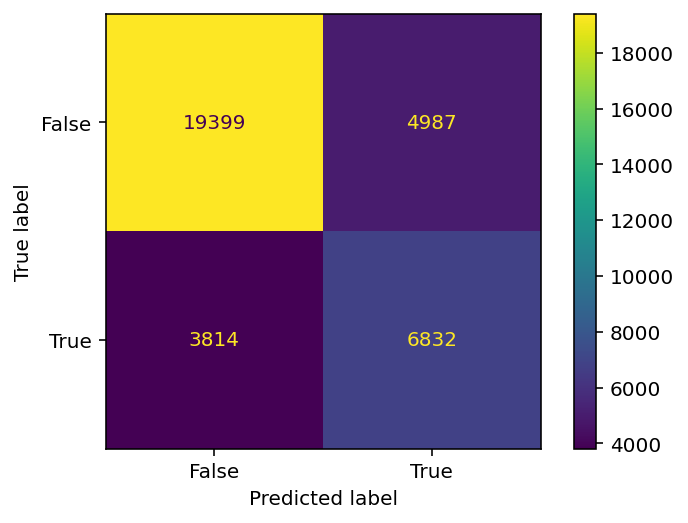

In [35]:
confusion_matrix = metrics.confusion_matrix(y_val, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [36]:
profit_index(y_pred, val_final)

Individual Cost: 15,918.0
Marketing Cost:	 169,464,906.0
Net Profit:	 16,946,491.0


In [37]:
model = XGBClassifier(random_state=221,
                      n_estimators=128,
                      scale_pos_weight=2.5,
                      max_depth=3,
                      min_child_weight=200
                      )

model.fit(X_train_val,y_train_val)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.70      0.77     12426
           1       0.57      0.75      0.65      6559

    accuracy                           0.72     18985
   macro avg       0.71      0.73      0.71     18985
weighted avg       0.75      0.72      0.73     18985



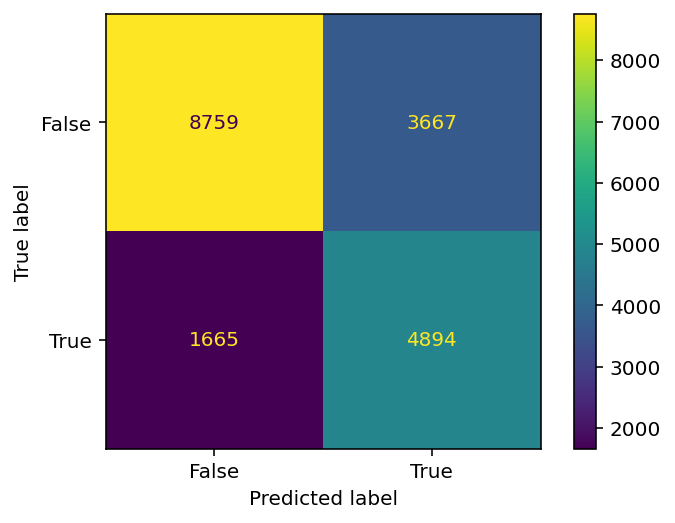

In [38]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [39]:
profit_index(y_pred, test_final)

Individual Cost: 19,661.0
Marketing Cost:	 128,959,666.0
Net Profit:	 12,895,967.0


In [40]:
# model save
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

# 추천 시스템 모델링

In [58]:
pdde = pd.read_csv('/content/drive/MyDrive/L.Pay_Competition/LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv')
pd_clac = pd.read_csv('/content/drive/MyDrive/L.Pay_Competition/LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv')
pdde = pd.merge(pdde, pd_clac, how='left', on='pd_c')
pdde.de_dt = pd.to_datetime(pdde.de_dt, format='%Y%m%d')
pdde = pdde[(pdde['cop_c'] != 'A05') & (pdde['cop_c'] != 'A06')]

In [59]:
cbf = pdde[['cust','cop_c','pd_c','clac_mcls_nm']]
cbf_item_id = pdde[['pd_c','clac_mcls_nm']].drop_duplicates()
cbf_user_data = pdde.groupby(['cust','pd_c']).agg({'buy_ct':'sum'}).reset_index()

In [9]:
def split_data_2(point):
    pdde['id'] = pdde[(pdde['cop_c'] != 'A05') & (pdde['cop_c'] != 'A06')].groupby(['cust','cop_c']).ngroup()
    set = pdde[pdde.de_dt.dt.month.between(point-2, point-1)]
    # Observation point (기준점)
    obs_point = dt.datetime(2021, point, 1)
    # y 생성
    target = pdde[pdde.de_dt.between(obs_point+dt.timedelta(7), obs_point+dt.timedelta(30))]
    target_id = target.id.unique()
    set['y'] = set.id.isin(target_id)==False
    set['y'] = set.y.astype('int')
    set['pd_c'] = pdde[pdde.de_dt.dt.month.between(point-2, point-1)]['pd_c']
    return set

In [10]:
split1 = split_data_2(3).groupby(['id', 'pd_c']). \
    agg({"buy_ct": "sum"}).reset_index()
split2 = split_data_2(5).groupby(['id', 'pd_c']). \
    agg({"buy_ct": "sum"}).reset_index()
split3 = split_data_2(7).groupby(['id', 'pd_c']). \
    agg({"buy_ct": "sum"}).reset_index()
split4 = split_data_2(9).groupby(['id', 'pd_c']). \
    agg({"buy_ct": "sum"}).reset_index()
test = split_data_2(11).groupby(['id', 'pd_c']). \
    agg({"buy_ct": "sum"}).reset_index()

In [11]:
# 고유 아이디 겹치지 않게 설정
split1['id'] += 100000
split2['id'] += 200000
split3['id'] += 300000
split4['id'] += 400000
test['id'] += 500000

In [80]:
split_data = pd.concat([split1, split2, split3, split4, test], axis=0)
split_data['buy_ct'] = np.where(split_data['buy_ct'] > 10, 10, split_data['buy_ct'])

In [81]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(split_data[['id', 'pd_c', 'buy_ct']], reader)
train, test = train_test_split(data, train_size=0.25, random_state=221)

In [82]:
model = NormalPredictor()
cross_validate(model, data, measures=['RMSE', 'MSE'], cv=4, verbose=True)

Evaluating RMSE, MSE of algorithm NormalPredictor on 4 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Mean    Std     
RMSE (testset)    2.2803  2.2834  2.2739  2.2789  2.2791  0.0034  
MSE (testset)     5.1998  5.2137  5.1708  5.1932  5.1944  0.0155  
Fit time          3.61    5.11    5.01    5.06    4.70    0.63    
Test time         9.77    7.83    8.90    7.82    8.58    0.82    


{'fit_time': (3.607496738433838,
  5.106825113296509,
  5.013874530792236,
  5.0562615394592285),
 'test_mse': array([5.19981049, 5.21370469, 5.17080345, 5.19316309]),
 'test_rmse': array([2.2803093 , 2.28335382, 2.27394007, 2.27885126]),
 'test_time': (9.774270057678223,
  7.832174777984619,
  8.89644479751587,
  7.815839767456055)}

In [83]:
model.fit(train)
pred = model.test(test)
print('MSE:',accuracy.mse(pred))
print('RMSE:',accuracy.rmse(pred))

MSE: 5.1921
MSE: 5.192107668231777
RMSE: 2.2786
RMSE: 2.2786196848600637


In [77]:
def get_unseen_surprise(ratings, items, userId):

    seen_items = ratings[ratings['id']== userId]['pd_c'].tolist()
    total_items = items['pd_c'].tolist()
    unseen_items = [ item for item in total_items if item not in seen_items]
    
    return unseen_items

In [76]:
def recomm_items_by_surprise(model, userId, ratings, items, top_n=10):
    
    unseen_items = get_unseen_surprise(ratings, items, userId)

    predictions = []
    for itemId in unseen_items:
        predictions.append(model.predict(str(userId), str(itemId)))
    
    def sortkey_est(pred):
        return pred.est

    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions = predictions[:top_n]
    reco = list()
    
    for pred in top_predictions:
        
        item_id = str(pred.iid)
        item_title = items[items["pd_c"] == item_id]["clac_mcls_nm"].tolist()
        item_rating = pred.est
        reco.append(item_title[0])

    return reco

In [50]:
test_final['id'] += 500000
X_test = test_final.iloc[:,2:-1]

In [53]:
xgb_model = XGBClassifier(random_state=221,
                      n_estimators=128,
                      scale_pos_weight=2.5,
                      max_depth=3,
                      min_child_weight=200
                      )

xgb_model.fit(X_train_val, y_train_val)
pred = xgb_model.predict(X_test)
test_final['y'] = pred

In [72]:
churn_cust = test_final[test_final['y'] == 1]['id']

In [84]:
recommand_list = list()

for id in churn_cust.to_list()[:100]:
  reco = recomm_items_by_surprise(model, id, split_data, cbf_item_id)
  reco = list(set(reco))
  recommand_list.append([id, reco])

In [85]:
for i in recommand_list[:30]:
  print(i)

[500003, ['생선회', '어묵/맛살', '건면', '일반담배', '홍삼/인삼가공식품', '소스류', '여성화', '여성의류상의', '축구', '이미용가전']]
[500019, ['건면', '성인침구', '유아동양말류', '사무용지/서식지', '주방가전', '여행용가방류', '일반의약외품', '수산선물세트', '등산', '수유/이유용품']]
[500021, ['세탁/건조용품', '스킨케어', '인스턴트커피', '여성속옷', '컴퓨터주변기기', '잎채소', '한방약재', '일반의약품', '노트', '그릇/식기']]
[500028, ['액세서리편의용품', '닭고기류', '여성속옷', '주방가구', '보석', '양채류', '골프', '조리도구', '양주', '여성위생용품']]
[500033, ['레토르트', '어묵/맛살', '지류상품권', '교육보조재', '국산소고기', '청소세제', '이미용가전', '기타고기류', '미용소품', '전기용품']]
[500034, ['스킨케어', '어묵/맛살', '조개류', '방향/제습/탈취제', '서적', '커피음료', '수유/이유용품', '등산', '필기도구', '전기용품']]
[500035, ['유아동속옷', '생선회', '갑각류', '욕실용품', '냉장간편식', '조리기구', '보수용품', '공기청정/가습/제습', '남성특수목적의류', '배구']]
[500041, ['남아의류하의', '수산물통조림', '남성등산/아웃도어의류', '아이스크림', '세탁세제', '어류', '여성스포츠화', '계란류', '남성의류아우터', '파티/팬시용품']]
[500043, ['분말류', '남성의류세트', '모자', '식용유류', '기타', 'TV', '사탕/캔디', '여성화', '유아동화', '여성의류상의']]
[500051, ['원예용품', '여아의류하의', '서적', '스낵류', '교환/정비용품', '우산/양산류', '탁구', '수입과일', '미용소품']]
[500058, ['냉동간편식', '수납가구', '사무용지/서식지', '미술용품'